# ИДЗ. Вариант 4
Выполнили Евсеев Евгений, Парахин Николай и Тимофей Тихонов
Группа: БПИ 212

## Условие
Файл «Данные.xls» содержит выборки из одной и той же базы данных о бывших заключенных.

Описание переменных:

recid – 1, если заключенный – рецидивист, то есть совершил повторное преступление, 0 иначе;

age – возраст заключенного в месяцах;

black – 1, если преступник – представитель негроидной расы, 0 иначе;

married – 1, если преступник женат, 0 иначе;

alcohol – 1, если у заключенного проблемы с алкоголем, 0 иначе; 

drugs – 1, если у заключенного проблемы с наркотиками, 0 иначе; 

felon – 1 если приговор за тяжкое преступление.

educ – количество лет школьного образования

rules – количество нарушений правил в тюрьме

В каждом варианте значение переменная recid известно во всех наблюдениях, кроме последних 50. Эти наблюдения оставлены для прогноза (будем считать, что это преступники, еще не совершившие рецидив).

Для выполнения задания выберите следующие переменные: recid – объясняемая переменная
age, black, married, alcohol, rules - регрессоры 

Рекомендации:
Можно из непрерывных переменных educ и rules сконструировать dummy-переменные и ввести их в модель. Например, dummy-переменная по возрасту:

age_22 – индикатор того, что возраст преступника до 22 лет,

age_22_30 – индикатор того, что возраст преступника от 22 до 30 лет и

age_30 – индикатор того, что возраст преступника свыше 30 лет.

При этом не забываем, что в модель включаем только любые 2 из 3 dummy-переменных (например, age_22 и age_30), чтобы не возникло мультиколлинеарности в данных.


__Выполните следующие пункты задания:__

16) Оцените три модели, связывающую вероятность повторного преступления с остальными признаками: 
    1) линейную, 
    2) логит, 
    3) пробит.

17) Дайте словесное описание полученных результатов на примере логит-модели. Какие из переменных получились значимыми? Выпишите оцененную ковариационную матрицу оценок коэффициентов.

18) По каждой модели рассчитайте оцените вероятность повторного преступления для всех наблюдений, включая 50 последних (где неизвестно значение recid). Есть ли заметные различия между прогнозируемыми вероятностями? В каких наблюдениях возникают наибольшие расхождения? Кому из ещё не совершивших рецидива бывших заключенных требуется уделить особое внимание?

19) На примере probit модели проверьте значимость модели в целом тестом отношения правдоподобия. Рассчитайте p-значение.
̂

20) Этот пункт сделайте для probit модели. Рассмотрим прогнозное правило типа 𝑙𝑜𝑤𝑖 = 1,
̂
если 𝑃(𝑙𝑜𝑤𝑖 = 1) > 𝑐 , иначе 𝑙𝑜𝑤𝑖 = 0 , где c – некое пороговое значение для
моделируемой вероятности. 
Чувствительностью называется доля верных прогнозов среди всех наблюдений, где 𝑙𝑜𝑤𝑖 = 1(способность модели правильно предсказывать «единички»).
Специфичностью называется доля верных прогнозов среди всех наблюдений, где 𝑙𝑜𝑤𝑖 = 0 (способность модели правильно предсказывать «нули»). Рассчитайте чувствительность и специфичность для разных пороговых значений c от 0 до 1, постройте график зависимости чувствительности и специфичности от c.
Требуется, чтобы прогнозная модель имела чувствительность не ниже 80%. Каким должен быть порог c? Какой специфичности можно добиться в этом случае?

In [25]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
# Data import
data = pd.read_csv('data/data_v4.csv', sep=';')
data = data.astype(float)
data.describe()

,recid,black,alcohol,drugs,married,felon,educ,rules,age
count,963.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000
mean,0.395639,0.467917,0.220138,0.238894,0.261599,0.313919,9.720632,1.229023,342.304047
std,0.489242,0.499216,0.414544,0.426619,0.439723,0.464313,2.396048,2.395414,120.245419
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,198.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,256.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,303.000000
75%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,11.000000,1.000000,388.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,18.000000,27.000000,933.000000


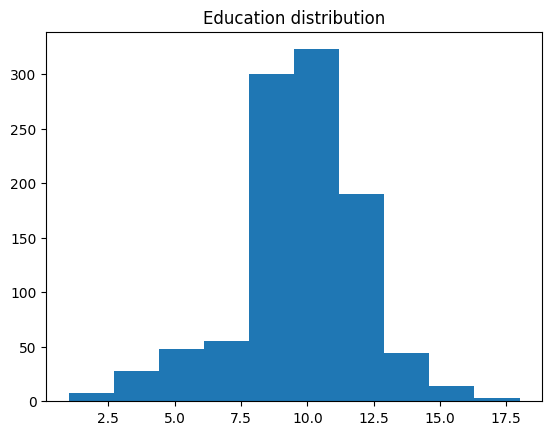

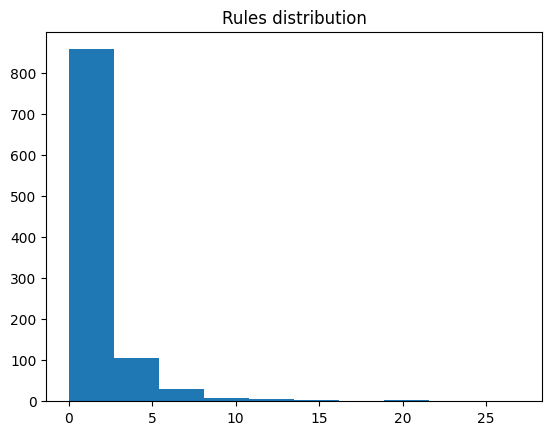

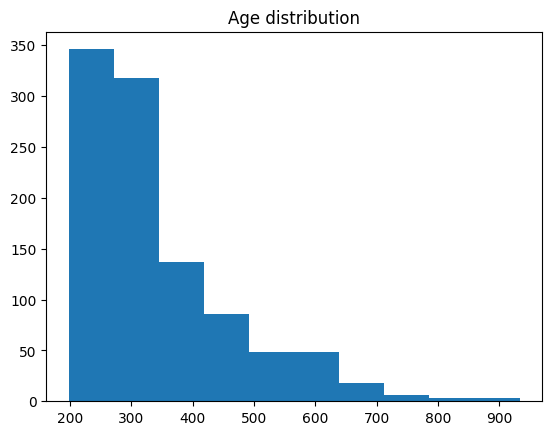

In [27]:
plt.hist(data['educ'], bins=10)
plt.title('Education distribution')
plt.show()

plt.hist(data['rules'], bins=10)
plt.title('Rules distribution')
plt.show()

plt.hist(data['age'], bins=10)
plt.title('Age distribution')
plt.show()

In [28]:
GROUPS_COUNT = 3

educ_bounds = [0]
for i in range(1, GROUPS_COUNT + 1):
    educ_bounds.append(data['educ'].quantile(i / GROUPS_COUNT))

rules_bounds = [0]
for i in range(1, GROUPS_COUNT + 1):
    rules_bounds.append(data['rules'].quantile(i / GROUPS_COUNT))

# TODO: fix
rules_bounds[1] = 0.01

print("Educ bounds", educ_bounds)
print("Rules bounds", rules_bounds)

Educ bounds [0, 9.0, 11.0, 18.0]
Rules bounds [0, 0.01, 1.0, 27.0]


In [29]:
# Education
educ_dummies = pd.get_dummies(pd.cut(data['educ'], educ_bounds))
educ_dummies_names = ['educ_' + str(educ_bounds[i]) + '_' + str(educ_bounds[i + 1]) for i in range(len(educ_bounds) - 1)]
educ_dummies = educ_dummies.astype(int)
educ_dummies.columns = educ_dummies_names
print(educ_dummies)

# Rules
rules_dummies = pd.get_dummies(pd.cut(data['rules'], rules_bounds))
rules_dummies_names = ['rules_' + str(rules_bounds[i]) + '_' + str(rules_bounds[i + 1]) for i in range(len(rules_bounds) - 1)]
rules_dummies = rules_dummies.astype(int)
rules_dummies.columns = rules_dummies_names
print(rules_dummies)

      educ_0_9.0  educ_9.0_11.0  educ_11.0_18.0
0              1              0               0
1              0              0               1
2              1              0               0
3              0              0               1
4              0              0               1
...          ...            ...             ...
1008           1              0               0
1009           0              0               1
1010           0              0               1
1011           0              0               1
1012           1              0               0

[1013 rows x 3 columns]
      rules_0_0.01  rules_0.01_1.0  rules_1.0_27.0
0                0               0               1
1                0               0               0
2                0               0               1
3                0               0               0
4                0               0               1
...            ...             ...             ...
1008             0               0        

In [35]:
data_needed = data[['recid', 'age', 'black', 'married', 'alcohol']]
data_w_d_col = pd.concat([data_needed, educ_dummies, rules_dummies], axis=1)
data_w_d_uncol = pd.concat([data_needed, educ_dummies.drop(educ_dummies.columns[2], axis=1), rules_dummies.drop(rules_dummies.columns[0], axis=1)], axis=1)

Посчитаем линейную модель:

In [36]:
# Linear regression

# Create X and y
data_w_d_uncol_no_na = data_w_d_uncol.dropna()
X = data_w_d_uncol_no_na.drop(['recid'], axis=1)
y = data_w_d_uncol_no_na['recid']
# Add constant
X = sm.add_constant(X)

# Fit model
model = sm.OLS(y, X).fit()

predictions = model.predict(X)

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  recid   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     8.124
Date:                Fri, 09 Jun 2023   Prob (F-statistic):           1.16e-10
Time:                        11:34:56   Log-Likelihood:                -645.76
No. Observations:                 963   AIC:                             1310.
Df Residuals:                     954   BIC:                             1353.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3287      0.060      5.

Посчитаем модель Logit

In [39]:
# Logit
# Using same X and Y

# Fit model
model = sm.Logit(y, X).fit()

predictions_l = model.predict(X)

# Print model summary
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.638539
         Iterations 5


AttributeError: 'LogitResults' object has no attribute 'fit'

Посчитаем модель Probit

In [32]:
# Probit

probit_m = sm.Probit(y, X)
predict_prob = probit_m.fit()
print(predict_prob.summary())

Optimization terminated successfully.
         Current function value: 0.638493
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:                  recid   No. Observations:                  963
Model:                         Probit   Df Residuals:                      954
Method:                           MLE   Df Model:                            8
Date:                Fri, 09 Jun 2023   Pseudo R-squ.:                 0.04873
Time:                        10:00:44   Log-Likelihood:                -614.87
converged:                       True   LL-Null:                       -646.37
Covariance Type:            nonrobust   LLR p-value:                 1.198e-10
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.4463      0.169     -2.647      0.008      -0.777      -0.116
age              

In [38]:
matrix = model.cov_params()
display(matrix)

AttributeError: 'Series' object has no attribute 'cov_params'